## Attributions

**Naveen:** Reviewed final solution

**Emily:** Tidied up/explanations of a-f, part g

**Chris:** Bulk of a-f

Loading BokehJS ...


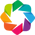

In [1]:
# Imports

import numpy as np
import pandas as pd

import bokeh.io
import bokeh.plotting

import holoviews as hv

import pymc3 as pm
import theano.tensor as tt
import theano

import bebi103

import scipy
import scipy.stats as st

import statsmodels.tools.numdiff as smnd

from IPython.display import display # Compatibility fix

bokeh.io.output_notebook()
hv.extension('bokeh')

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

Before we start the problem lets take a look at our data:

In [2]:
# Load data file stored in /data folder
df = pd.read_csv('../data/gardner_mt_catastrophe_only_tubulin.csv', comment='#')

df.head()

12 uM  7 uM  9 uM  10 uM  14 uM
0  25.000  35.0  25.0   50.0   60.0
1  40.000  45.0  40.0   60.0   75.0
2  40.000  50.0  40.0   60.0   75.0
3  45.429  50.0  45.0   75.0   85.0
4  50.000  55.0  50.0   75.0  115.0

It seems that our data is not tidy, but that's fine for the purpose of this problem since we're only considering each tubulin concentration separately. Now time for the problem.

**a)** For the exponential model, we're modeling microtobule catastrophe as a single step Poisson process where the arrival rate is memory-less. This will fit best when the time of catastrophe doesn't depend on how long it's been since the most recent catastrophe. In this case, we're using $\tau = 1/r$ so our paramater $\tau$ represents the characteristic arrival time which is the expected time in between catastrophes.

For the Gamma model, we once again treat microtubule catastrophe as a memoryless event, but it's now the result of $a$ independent Poisson processes, each with a characteristic time $\tau$ between the memoryless events. i.e. it takes $a$ independent events to trigger a catastrophe, with $\tau$ being the time between each $a$ event.

For the Weibull model, we aren't assuming the events are memory-less anymore. In this case, we're waiting for an exponentially distributed event with characteristic time $\tau$ between events, but now with more time in between events (the closer $t$ gets to $\tau$), there is either a higher or lower likelihood of another event happening depending on our parameter $\beta$. If $\beta > 1$, then the longer we wait the more likely the event will occur, and if $\beta < 1$ then the less likely it'll happen.

<div class="alert alert-info">
a: 6/6  
Nice explanations!
</div>

**b)** To use optimization for parameter estimation, we first need to write down functions for our log-likelihoods and priors. It seems appropriate in this case to use a Jeffrey's prior for $\tau, a, \beta$ across positive reals, since they're all "scaling"-type parameters in the models. As we know now, it doesn't make a huge difference whether we use Jeffreys or uniform, though.

In [3]:
# Exponential model

def log_like_exp(tau, ti):
    """ Log-likelihood for exp model """
    return -len(ti) * np.log(tau) - np.sum(ti / tau) 

def log_prior_exp(tau):
    """ Log-prior for exp model """
    if tau < 0:
        return -np.inf
    
    return -np.log(tau)

def log_post_exp(tau, ti):
    """ Log-posterior for exp model """
    lp = log_prior_exp(tau)
    
    if lp == -np.inf:
        return lp
    
    return log_like_exp(tau, ti) + lp

def neg_log_post_exp(tau, ti):
    """ Negative log-posterior for exp model """
    return -log_post_exp(tau, ti)


In [4]:
# Gamma model

def log_like_gam(params, ti):
    """ Log-likelihood for Gamma model """
    tau, a = params
    
    # Split likelihood as prod( ti^(a-1) * (tau^a gamma(tau))^-1 * exp(-ti/tau) )
    return ( (a-1) * np.sum(np.log(ti)) - np.sum(ti / tau)
             - len(ti) * (a * np.log(tau) + np.log(scipy.special.gamma(a))) )

def log_prior_gam(params):
    """ Log-prior for Gamma model """
    tau, a = params
    
    if tau < 0 or a < 0:
        return -np.inf
    
    return -np.log(tau * a)

def log_post_gam(params, ti):
    """ Log-posterior for Gamma model """
    lp = log_prior_gam(params)
    
    if lp == -np.inf:
        return lp
    
    return log_like_gam(params, ti) + lp

def neg_log_post_gam(params, ti):
    """ Negative log-posterior for Gamma model """
    return -log_post_gam(params, ti)

In [5]:
# Weibull model

def log_like_wbl(params, ti):
    """ Log-likelihood for Weibull model """
    tau, b = params
    
    # Rewrite as prod( beta/tau^beta * ti^beta-1 * exp(-ti/tau^beta))
    return ( len(ti) * (np.log(b) - b * np.log(tau)) + (b-1) * np.sum(np.log(ti))
             - np.sum(np.power(ti / tau, b)) )

def log_prior_wbl(params):
    """ Log-prior for Weibull model """
    tau, b = params
    
    if tau < 0 or b < 0:
        return -np.inf
    
    return -np.log(tau * b)

def log_post_wbl(params, ti):
    """ Log-posterior for Weibull model """    
    lp = log_prior_wbl(params)
    
    if lp == -np.inf:
        return lp
    
    return log_like_wbl(params, ti) + lp

def neg_log_post_wbl(params, ti):
    """ Negative log-posterior for Weibull model """
    return -log_post_wbl(params, ti)

Now we can optimize our functions to find the MAP paramters using the 3 different models.

In [6]:
# Taking out the slice of data for the concentration we want
times12 = df['12 uM'].values

# efficiency! make everything go in an array and iterate
models = [neg_log_post_exp, neg_log_post_gam, neg_log_post_wbl]
posts = [log_post_exp, log_post_gam, log_post_wbl]
likes = [log_like_exp, log_like_gam, log_like_wbl]
names = ['Exponential', 'Gamma', 'Weibull']

params_0 = [np.array([1.0]),
          np.array([1.0, 1.0]),
          np.array([1.0, 1.0])]
params = []
cov = []

# Optimize parameters using each model
for index, model in enumerate(models):

    res = scipy.optimize.minimize(model, params_0[index], args=(times12))
    params += [(res.x)]
    cov += [-np.linalg.inv(smnd.approx_hess(res.x, posts[index], args=(times12,)))]

# Place all parameters in a single list for printing
print_params = []
for array in params:
    print_params += [item for item in array]

print("""
      Exponential model:
      -----------------
      tau = {0:.1f} \n
      Gamma model:
      -----------
      tau = {1:.1f}
      a = {2:.1f} \n
      Weibull model:
      -------------
      tau = {3:.1f}
      beta = {4:.1f}
      """.format(*print_params))


      Exponential model:
      -----------------
      tau = 380.0 

      Gamma model:
      -----------
      tau = 130.5
      a = 2.9 

      Weibull model:
      -------------
      tau = 428.7
      beta = 1.8
      


From the probable parameters, we can see that the characteristic times are similar for the Weibull and Exponential models and the $\tau * a = 378.45$, which would be equivalent of $\tau$ for the other two cases, is also similar for the Gamma model. Now let's see how these look plotted against the data:

<div class="alert alert-info">
b: 8/9  
Great job specifying your likelihoods, priors, and posteriors explicitly!  However, you should include error bars when computing parameter estimates (either here or in part e).
</div>

**c)** Plotting the ECDF against the theoretical CDFs from the three different models, we get the following graph:

In [7]:
# Generate plots    
p = bebi103.viz.ecdf(times12)

x = np.linspace(0, np.max(times12), 10000)

# Add exponential model CDF
p.line(x, st.expon.cdf(x, scale=params[0]), color='tomato', legend='Exp')
# Gamma model CDF
p.line(x, st.gamma.cdf(x, a=round(params[1][1]), scale=params[1][0]), color='magenta', legend='Gam')
# Weibull model CDF
p.line(x, st.weibull_min.cdf(x, c=params[2][1], scale=params[2][0]), color='black', legend='Wbl')

p.legend.location='bottom_right'

bokeh.io.show(p)

It appears that both the Gamma and Weibull models give similar results that mostly fit the experimental data - especially at the beginning, a little poorer near the top bend in the sigmoidal curve - while the Exponential model is significantly worse than the other two. We'll try to confirm these results by computing the odds ratios between the three models.

**d)** 

<div class="alert alert-info">
c: 5/5  
Great visualization and analysis!
</div>

In [8]:
for index1, model1 in enumerate(likes[:-1]):
    for index2, model2 in enumerate(likes[1:]):
        if model1 != model2:
            log_good_fit_ratio = ( model1(params[index1], times12) -
                                   model2(params[index2+1], times12) )
            try:
                log_good_fit_ratio = log_good_fit_ratio[0]
            except IndexError:
                pass
            log_occam_factor = ( -np.log(2 * np.pi) + np.log(np.linalg.det(cov[index1]))
                                 - np.log(np.linalg.det(cov[index2+1])) ) / 2
            log_odds_ratio = log_good_fit_ratio + log_occam_factor
            print( 'Odds ratio (good fit/occam factor) for ' + names[index1] + '/' + names[index2+1]
                    + ': ' + str(np.exp(log_odds_ratio)) + ' (' + str(np.exp(log_good_fit_ratio)) + '/'
                    + str(np.exp(log_occam_factor)) + ')' ) 
            

Odds ratio (good fit/occam factor) for Exponential/Gamma: 6.99284543073e-72 (5.24153132022e-73/13.3412260721)
Odds ratio (good fit/occam factor) for Exponential/Weibull: 2.29793869997e-64 (1.80211968964e-65/12.7513100998)
Odds ratio (good fit/occam factor) for Gamma/Weibull: 13109755.0242 (34381549.5805/0.381302040894)


<div class="alert alert-info">
-1.5: Your Occam factor calculations do not account for the prior probability of the MAP parameter estimate or the number of parameters (which factors into the calculation with <tt>2&pi;</tt>) in each model.  See Lecture 5 for more details, and come to office hours with any questions!  
</div>

Note: the (good fit/occam factor) just represents those values in the output, it doesn't mean that they're divided.

Based on our odds ratios, the Gamma function should be the best way to model tubulin catastrophe, since the odds ratio shows Gamma is more probable than Weibull by a little bit (order of$10^8$) and than exponential by a lot (order of$~10^{72}$). Basically we can ignore the exponential at this point because it's clearly a worse fit than either of the other two.

With the goodness of fit values, we see again how poor the Exponential fit compares to the Gamma and Weibull - many orders of magnitudes ($>10^{65}$) worse. Between the Gamma/Weibull, Gamma still gives the larger number/better fit. 

Looking at the Occam factor ratio between Gamma/Weibull, we see that Gamma/Weibull < 1, which means Gamma is actually less probable than Weibull, but only slightly. However, this doesn't really overpower the$~10^8$ difference between the two noted by the odds ratio as well as the goodness of fit values, which indicates that the Gamma function is still the better fit. 

<div class="alert alert-info">
d: 6.5/8  
Great analysis of the contributions of the goodness of fit and Occam factor for each pair of models!
</div>

**e)** Now let's see if we can get the same results using MCMC. We'll first start by building our three different models:

In [9]:
with pm.Model() as exp_model:
    # Priors
    lam = pm.HalfFlat('lam')
    
    # Likelihood
    n_obs = pm.Exponential('n_obs', lam=lam, observed=times12)
    
    # Draw samples
    trace_exp = pm.sample(draws=10000, tune=10000, njobs=2, init='advi+adapt_diag')
    
    # Convert to data frame
    df_exp = bebi103.pm.trace_to_dataframe(trace_exp, log_post=True)
    
with pm.Model() as gam_model:
    # Priors
    alpha = pm.HalfFlat('alpha')
    b = pm.HalfFlat('b')
    
    # Likelihood where beta = 1/tau
    n_obs = pm.Gamma('n_obs', alpha=alpha, beta=b, observed=times12)
    
    # Draw samples
    trace_gam = pm.sample(draws=10000, tune=10000, njobs=2, init='advi+adapt_diag')
    
    # Convert to data frame
    df_gam = bebi103.pm.trace_to_dataframe(trace_gam, log_post=True)
    
    # Calculate tau
    df_gam['tau'] = 1 / df_gam['b']
    
with pm.Model() as wbl_model:
    # Priors
    beta = pm.HalfFlat('beta')
    tau = pm.HalfFlat('tau')
    
    # Likelihood b = tau, a = beta
    n_obs = pm.Weibull('n_obs', alpha=beta, beta=tau, observed=times12)
    
    # Draw samples
    trace_wbl = pm.sample(draws=10000, tune=10000, njobs=2, init='advi+adapt_diag')
    
    # Convert to data frame
    df_wbl = bebi103.pm.trace_to_dataframe(trace_wbl, log_post=True)
    

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO:pymc3:Initializing NUTS using advi+adapt_diag...
Average Loss = 17,977:   5%|█▉                                   | 10395/200000 [00:10<03:11, 991.00it/s]
Convergence archived at 10500
INFO:pymc3.variational.inference:Convergence archived at 10500
Interrupted at 10,499 [5%]: Average Loss = 1.0173e+05
INFO:pymc3.variational.inference:Interrupted at 10,499 [5%]: Average Loss = 1.0173e+05
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO:pymc3:Initializing NUTS using advi+adapt_diag...
Average Loss = 5,081.7:  10%|███▊                                | 20982/200000 [00:21<03:05, 962.61it/s]
Convergence archived at 21000
INFO:pymc3.variational.inference:Convergence archived at 21000
Interrupted at 20,999 [10%]: Average Loss = 50,699
INFO:pymc3.variational.inference:Interrupted at 20,999 [10%]: Average 

Time to plot our samples...

In [10]:
# Generate plots    
p = bebi103.viz.ecdf(times12)

x = np.linspace(0, np.max(times12), 1000)

for _, row in df_exp.loc[::1000, ['lam']].iterrows():
    # Add exponential model CDF
    p.line(x, st.expon.cdf(x, scale=1/row['lam']), line_width=0.5,
           alpha=0.15, color='tomato', legend='Exp')
    
for _, row in df_gam.loc[::1000, ['alpha', 'b']].iterrows():
    # Add gamma model CDF
    p.line(x, st.gamma.cdf(x, a=round(row['alpha']), scale=1/row['b']),
           line_width=0.5, alpha=0.15, color='magenta', legend='Gam')
    
for _, row in df_wbl.loc[::1000, ['beta', 'tau']].iterrows():
    # Add weibull model CDF
    p.line(x, st.weibull_min.cdf(x, c=row['beta'], scale=row['tau']), 
           line_width=0.5, alpha=0.15, color='black', legend='Wbl')

p.legend.location='bottom_right'

bokeh.io.show(p)

We can see similar results using MCMC as we did using parameter estimation; however, using MCMC, we can see that the the spread of Gamma model solutions (purple-pink) seems to be larger than that of the Weibull model solutions. Now let's calculate the WAIC to compare the models:

In [11]:
pm.compare((trace_exp, trace_gam, trace_wbl), (exp_model, gam_model, wbl_model))

WAIC pWAIC   dWAIC weight     SE    dSE warning
1  9278.75  2.33       0   0.99  45.52      0       0
2  9314.17  3.03   35.42      0  48.21  10.16       1
0  9608.57  0.37  329.82   0.01  32.04  28.36       0

- 0 = Exponential
- 1 = Gamma
- 2 = Weibull

We can see that we get the same results using WAIC for model selection. The lowest WAIC value belongs to the Gamma model and the next lowest is the Weibull model (though this WAIC value may not be accurate according to the warning). Lastly, the exponential model is significantly worse which is what we expected based on our previous analysis and the graphs. This means for the other data sets, we should try to use the Gamma model. Also this confirms that our MCMC sampler works and is consistent with Pymc3, which is good.

**e)** Now we'll try to use the Gamma model to fit catastrophe times for the other microtubule concentrations:

<div class="alert alert-info">
e: 13/16  
Nice work!  However, you should show the parameter estimates (and error bars) to confirm that they match the results of optimization.
</div>

In [12]:
f_params = [(np.mean(df_gam['alpha']), np.mean(df_gam['tau']))]

observed_names = ['12 uM', '7 uM', '9 uM', '10 uM', '14 uM']

observed = [df[name].dropna().values for name in observed_names]

for conc in observed[1:]:
    with pm.Model() as gam_model:
        # Priors
        alpha = pm.HalfFlat('alpha')
        b = pm.HalfFlat('b')

        # Likelihood where beta = 1/tau
        n_obs = pm.Gamma('n_obs', alpha=alpha, beta=b, observed=conc)

        # Draw samples
        trace_gam = pm.sample(draws=10000, tune=10000, njobs=1, init='advi+adapt_diag')

        # Convert to data frame
        df_gam = bebi103.pm.trace_to_dataframe(trace_gam, log_post=True)

        # Calculate tau
        df_gam['tau'] = 1 / df_gam['b']

        # Calculate average parameter values
        tau_avg = np.mean(df_gam['tau'])
        alpha_avg = np.mean(df_gam['alpha'])
        
        f_params.append((alpha_avg, tau_avg))

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO:pymc3:Initializing NUTS using advi+adapt_diag...
Average Loss = 4,355.2:  11%|███▊                                | 21019/200000 [00:21<03:00, 990.41it/s]
Convergence archived at 21100
INFO:pymc3.variational.inference:Convergence archived at 21100
Interrupted at 21,099 [10%]: Average Loss = 38,007
INFO:pymc3.variational.inference:Interrupted at 21,099 [10%]: Average Loss = 38,007
100%|█████████████████████████████████████████████████████████████| 20000/20000 [00:21<00:00, 909.70it/s]
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO:pymc3:Initializing NUTS using advi+adapt_diag...
Average Loss = 1,799.8:  10%|███▋                               | 20851/200000 [00:20<02:53, 1031.75it/s]
Convergence archived at 20900
INFO:pymc3.variational.inference:Convergence archived at 20900
Interrupted at 20,899

In [13]:
for index, name in enumerate(observed_names):
    print('Parameters (alpha, tau) for ' + name + ': ' +
          str(f_params[index][0]) + ', ' + str(f_params[index][1]))

Parameters (alpha, tau) for 12 uM: 2.927468121677455, 130.3847176361278
Parameters (alpha, tau) for 7 uM: 2.4574641886949298, 132.08321693775378
Parameters (alpha, tau) for 9 uM: 2.713039778570183, 113.24738627754536
Parameters (alpha, tau) for 10 uM: 3.2542089395165688, 110.20026335429186
Parameters (alpha, tau) for 14 uM: 3.428573793940078, 138.44938289014493


In [14]:
sizes = [12, 7, 9, 10, 14]

p = bokeh.plotting.figure(plot_width=500,
                          plot_height=400,
                          y_axis_label='tau',
                          x_axis_label='length (uM)')

p.circle(sizes, [item[1] for item in f_params], legend='tau')
p.circle(sizes, [item[0] * item[1] for item in f_params], color='tomato', legend='tau * alpha')

p.legend.location='top_left'

bokeh.io.show(p)

We can see that there isn't a particularly strong correlation between lengths and just catastrophe times, however if we include catastrophe times * events, we get a strong postitive correlation between lengths and our new metric, suggesting there are a combination of larger number of events that need to occur and longer times between those events when microtubule length increases.
Because we're using the Gamma model, it makes sense for the tau values to go down as concentrations go up (events will happen more frequently with higher tubulin concentrations, as stated in the problem). However, it does go back up for 12 uM and up, perhaps because it saturated or too high of a concentration is actually worse for polymerization (maybe it causes faster degradation)?

<div class="alert alert-info">
f: 4/4  
Great analysis!
</div>

**g)** Let's start by reading in the data from the Kip3 experiments with 12 uM tubulin.

In [15]:
# Load data file stored in /data folder
df_kip3 = pd.read_csv('../data/gardner_mt_catastrophe_kip3.csv', comment='#')

# Display
display(df_kip3.tail())

18 nM Kip3  14 nM Kip3  7 nM Kip3
261         NaN         750        NaN
262         NaN         790        NaN
263         NaN         940        NaN
264         NaN        1000        NaN
265         NaN        1100        NaN

Yikes, there are some NaNs. Let's get rid of those.

In [16]:
df_kip3 = df_kip3.dropna()

<div class="alert alert-info">
-1: You cannot use <tt>dropna</tt> directly, as you are getting rid of rows that do contain data (for instance, measurements with 14 nM Kip3).  You need to melt the data first, so that each row corresponds to exactly one measurement.
</div>

Let's first try fitting the data at the 4 different concentrations with each of the 3 models: Exponential, Gamma, Weibull. We'll utilize the functions we wrote above for each model. 

In [17]:
conc_str = ['7 nM Kip3','14 nM Kip3','18 nM Kip3']
for conc in conc_str:
    # Taking out the slice of data for the concentration we want
    times = df_kip3[conc].values

    # efficiency! make everything go in an array and iterate
    models = [neg_log_post_exp, neg_log_post_gam, neg_log_post_wbl]
    posts = [log_post_exp, log_post_gam, log_post_wbl]
    likes = [log_like_exp, log_like_gam, log_like_wbl]
    names = ['Exponential', 'Gamma', 'Weibull']

    params_0 = [np.array([1.0]),
              np.array([1.0, 1.0]),
              np.array([1.0, 1.0])]
    params = []
    cov = []

    # Optimize parameters using each model
    for index, model in enumerate(models):

        res = scipy.optimize.minimize(model, params_0[index], args=(times))
        params += [(res.x)]
        cov += [-np.linalg.inv(smnd.approx_hess(res.x, posts[index], args=(times,)))]

    # Place all parameters in a single list for printing
    print_params = []
    for array in params:
        print_params += [item for item in array]
        
    print(conc + ' Concentration fit:')

    print("""
          Exponential model:
          -----------------
          tau = {0:.1f} \n
          Gamma model:
          -----------
          tau = {1:.1f}
          a = {2:.1f} \n
          Weibull model:
          -------------
          tau = {3:.1f}
          beta = {4:.1f}
          """.format(*print_params))

7 nM Kip3 Concentration fit:

          Exponential model:
          -----------------
          tau = 293.2 

          Gamma model:
          -----------
          tau = 118.8
          a = 2.5 

          Weibull model:
          -------------
          tau = 330.6
          beta = 1.7
          
14 nM Kip3 Concentration fit:

          Exponential model:
          -----------------
          tau = 175.6 

          Gamma model:
          -----------
          tau = 29.2
          a = 6.0 

          Weibull model:
          -------------
          tau = 197.8
          beta = 3.1
          
18 nM Kip3 Concentration fit:

          Exponential model:
          -----------------
          tau = 114.9 

          Gamma model:
          -----------
          tau = 23.1
          a = 5.0 

          Weibull model:
          -------------
          tau = 130.4
          beta = 2.5
          


Okay, not bad. Interestingly, the $\tau$ value for Exponential and $\tau a$ for Gamma are much closer together than the $\tau$ for Weibull at all concentrations. This doesn't tell us too much yet; let's plot it.

In [18]:
for conc in conc_str:
    # Taking out the slice of data for the concentration we want
    times = df_kip3[conc].values
    # Generate plots    
    p = bebi103.viz.ecdf(times, title = conc + ' ECDF')

    x = np.linspace(0, np.max(times), 10000)

    # Add exponential model CDF
    p.line(x, st.expon.cdf(x, scale=params[0]), color='tomato', legend='Exp')
    # Gamma model CDF
    p.line(x, st.gamma.cdf(x, a=round(params[1][1]), scale=params[1][0]), color='magenta', legend='Gam')
    # Weibull model CDF
    p.line(x, st.weibull_min.cdf(x, c=params[2][1], scale=params[2][0]), color='black', legend='Wbl')

    p.legend.location='bottom_right'

    bokeh.io.show(p)

Wow okay so the models actually really suck for the lower concentrations. I probably won't proceed with analysis on the two lower concentrations because
1. The models do not fit low concentrations well and it wouldn't produce meaningful results if I continued to analyze them in this way
2. Kip3 at 18 nM concentration should yield the biggest difference in results between the standard (no kinesin) catastrophe and be the most meaningful indicator of Kip3 relationship with catastrophe.

For 18 nM Kip3, we see that the Gamma and Weibull models fit pretty well with the sigmoidal curve but not so much the Exponential. This is promising. So, let's proceed with the fit for 18 nM Kip3 and analyze the odds ratio, goodness of fit, and Occam factor for each combination.

<div class="alert alert-info">
-1: Since <tt>params</tt> does not change between iterations of the loop, you are plotting the same curve each time.  The real values should give you much better fits.
</div>

In [19]:
times18 = df_kip3['18 nM Kip3'].values

for index1, model1 in enumerate(likes[:-1]):
    for index2, model2 in enumerate(likes[1:]):
        if model1 != model2:
            log_good_fit_ratio = ( model1(params[index1], times18) -
                                   model2(params[index2+1], times18) )
            try:
                log_good_fit_ratio = log_good_fit_ratio[0]
            except IndexError:
                pass
            log_occam_factor = ( -np.log(2 * np.pi) + np.log(np.linalg.det(cov[index1]))
                                 - np.log(np.linalg.det(cov[index2+1])) ) / 2
            log_odds_ratio = log_good_fit_ratio + log_occam_factor
            print( 'Odds ratio (good fit/occam factor) for ' + names[index1] + '/' + names[index2+1]
                    + ': ' + str(np.exp(log_odds_ratio)) + ' (' + str(np.exp(log_good_fit_ratio)) + '/'
                    + str(np.exp(log_occam_factor)) + ')' ) 

Odds ratio (good fit/occam factor) for Exponential/Gamma: 1.40954931238e-36 (1.5977014429e-37/8.82235738498)
Odds ratio (good fit/occam factor) for Exponential/Weibull: 3.44875167959e-36 (5.64876870499e-37/6.10531579483)
Odds ratio (good fit/occam factor) for Gamma/Weibull: 0.976094165359 (3.53555961916/0.276079113493)


Alright - the odds ratio, goodness of fit, and Occam factor all indicate that, as expected, the Exponential model is a pretty bad fit. Between the Gamma and the Weibull, the odds ratio indicates that they're both really close in probability, as the value is super close to 1 (~0.976); Gamma slightly worse than Weibull. The goodness of fit indicates that Gamma is a slightly better fit than Weibull by a factor of ~3.5, while the Occam factor actually indicates that Weibull is ~3.5x more probable than Gamma. The Occam factor and goodness of fit values kind of even themselves out when multiplied to get the odds ratio. Seems like using either fit is okay overall, but picking one might depend on what you value more in the fit based on what you already know about the system.

I will pick the Gamma fit to draw a conclusion, since that is the model we used above for the no-kinesin cases. From the catastrophe analysis above, with no kinesin, we get:
- $\alpha$ =  2.93, $\tau$ = 130.18, $\alpha \tau$ = 381.4274

While for Kip3 Gamma fit we had:
- $\alpha$ =  5.0, $\tau$ = 23.1, $\alpha \tau$ = 115.5

We can see a clear difference in the $\alpha \tau$ values, which should represent the lifetimes of the microtubules before catastrophe. With the larger concentration of Kip3, the lifetime is more than 3x shorter than without. As a result, we can conclude that Kip3 is in fact a catastrophe factor, decreasing microtubule lifetimes.

<div class="alert alert-info">
-1: You can use the estimates for $\tau$ and $a$ to speculate about the biological roles of Kip3 and MCAK in catastrophe.  You correctly identified that both decrease microtubule lifetimes, but you can extend the analysis further.  Here, for instance, it is interesting to note that the effect of Kip3 is predominantly on $\tau$.
</div>

Now that we've established the relationship for Kip3, let's work with MCAK.

In [20]:
# Read in data
df_mcak = pd.read_csv('../data/gardner_mt_catastrophe_mcak.csv', comment='#')
df_mcak = df_mcak.dropna()

# Display
df_mcak.head()

9 nM MCAK  7 nM MCAK  5 nM MCAK  2.4 nM MCAK
0         15       15.0       15.0         35.0
1         15       20.0       20.0         40.0
2         20       25.0       20.0         40.0
3         25       25.0       20.0         45.0
4         25       25.0       25.0         45.0

In [21]:
conc_str = ['2.4 nM MCAK','5 nM MCAK','7 nM MCAK', '9 nM MCAK']
for conc in conc_str:
    # Taking out the slice of data for the concentration we want
    times = df_mcak[conc].values

    # efficiency! make everything go in an array and iterate
    models = [neg_log_post_exp, neg_log_post_gam, neg_log_post_wbl]
    posts = [log_post_exp, log_post_gam, log_post_wbl]
    likes = [log_like_exp, log_like_gam, log_like_wbl]
    names = ['Exponential', 'Gamma', 'Weibull']

    params_0 = [np.array([1.0]),
              np.array([1.0, 1.0]),
              np.array([1.0, 1.0])]
    params = []
    cov = []

    # Optimize parameters using each model
    for index, model in enumerate(models):

        res = scipy.optimize.minimize(model, params_0[index], args=(times))
        params += [(res.x)]
        cov += [-np.linalg.inv(smnd.approx_hess(res.x, posts[index], args=(times,)))]

    # Place all parameters in a single list for printing
    print_params = []
    for array in params:
        print_params += [item for item in array]
        
    print(conc + ' Concentration fit:')

    print("""
          Exponential model:
          -----------------
          tau = {0:.1f} \n
          Gamma model:
          -----------
          tau = {1:.1f}
          a = {2:.1f} \n
          Weibull model:
          -------------
          tau = {3:.1f}
          beta = {4:.1f}
          """.format(*print_params))

2.4 nM MCAK Concentration fit:

          Exponential model:
          -----------------
          tau = 366.7 

          Gamma model:
          -----------
          tau = 219.1
          a = 1.7 

          Weibull model:
          -------------
          tau = 401.5
          beta = 1.3
          
5 nM MCAK Concentration fit:

          Exponential model:
          -----------------
          tau = 81.5 

          Gamma model:
          -----------
          tau = 18.2
          a = 4.5 

          Weibull model:
          -------------
          tau = 92.4
          beta = 2.5
          
7 nM MCAK Concentration fit:

          Exponential model:
          -----------------
          tau = 114.5 

          Gamma model:
          -----------
          tau = 39.3
          a = 2.9 

          Weibull model:
          -------------
          tau = 129.9
          beta = 2.0
          
9 nM MCAK Concentration fit:

          Exponential model:
          -----------------
          ta

Nice, now we can plot to elucidate the appropriateness of fits.

In [22]:
for conc in conc_str:
    # Taking out the slice of data for the concentration we want
    times = df_mcak[conc].values
    # Generate plots    
    p = bebi103.viz.ecdf(times, title = conc + ' ECDF')

    x = np.linspace(0, np.max(times), 10000)

    # Add exponential model CDF
    p.line(x, st.expon.cdf(x, scale=params[0]), color='tomato', legend='Exp')
    # Gamma model CDF
    p.line(x, st.gamma.cdf(x, a=round(params[1][1]), scale=params[1][0]), color='magenta', legend='Gam')
    # Weibull model CDF
    p.line(x, st.weibull_min.cdf(x, c=params[2][1], scale=params[2][0]), color='black', legend='Wbl')

    p.legend.location='bottom_right'

    bokeh.io.show(p)

Yikes. Once again, the models fit really poorly for the 3 lower concentrations, so I'll proceed with the highest one at 9 nM MCAK for the same reasons stated above for Kip3.

<div class="alert alert-info">
-2: Same issues with dropping valid measurements and plotting fits with the same parameters.
</div>

In [23]:
times9 = df_mcak['9 nM MCAK'].values

for index1, model1 in enumerate(likes[:-1]):
    for index2, model2 in enumerate(likes[1:]):
        if model1 != model2:
            log_good_fit_ratio = ( model1(params[index1], times9) -
                                   model2(params[index2+1], times9) )
            try:
                log_good_fit_ratio = log_good_fit_ratio[0]
            except IndexError:
                pass
            log_occam_factor = ( -np.log(2 * np.pi) + np.log(np.linalg.det(cov[index1]))
                                 - np.log(np.linalg.det(cov[index2+1])) ) / 2
            log_odds_ratio = log_good_fit_ratio + log_occam_factor
            print( 'Odds ratio (good fit/occam factor) for ' + names[index1] + '/' + names[index2+1]
                    + ': ' + str(np.exp(log_odds_ratio)) + ' (' + str(np.exp(log_good_fit_ratio)) + '/'
                    + str(np.exp(log_occam_factor)) + ')' ) 

Odds ratio (good fit/occam factor) for Exponential/Gamma: 5.4834838532e-42 (5.72778340455e-43/9.57348325855)
Odds ratio (good fit/occam factor) for Exponential/Weibull: 6.47624899554e-45 (1.14802868238e-45/5.64119093446)
Odds ratio (good fit/occam factor) for Gamma/Weibull: 0.000471169353625 (0.00200431580822/0.23507740232)


The odds ratio, goodness of fit, and Occam factor all indicate that, as expected, the Exponential model is a pretty bad fit once again. Between the Gamma and the Weibull, the odds ratio indicates that this time, the Gamma is much less appropriate than the Weibull for this data set. Looking more closely at the goodness of fit and the Occam factor, they also both indicate that the Weibull is the better fit as well as the more probable one. 

As such, let's use the Weibull fit to draw a conclusion. Unfortunately, from the catastrophe analysis above, with no kinesin, our fit with the Weibull is not as good as the one for Gamma, but it's still okay-ish. The values from that fit are:
- $\beta$ = 1.8, $\tau$ = 428.7

While for MCAK 9 nM fit we had:
- $\beta$ = 3.1, $\tau$ = 65.5

We can see a clear difference in the $\tau$ values, which should represent the lifetimes of the microtubules before catastrophe. With the larger concentration of MCAK, the lifetime is more than ~6.5x shorter than without. As a result, we can conclude that MCAK is also a catastrophe factor, decreasing mean microtubule lifetimes. Both our results for Kip3 and MCAK are consistent with those of the paper, which is good!


<div class="alert alert-info">
g: 15/20  
Overall, nice job!  A few technical issues, but you came at the problem with the right approach!
</div>

<div class="alert alert-info">
Other: 2/2  
Good explanations of code cells and clear attributions.  Note, however, that the course policies state that there should be no adjacent code cells.
</div>

<div class="alert alert-info">
Total: 59.5/50 (44.5/50, +15)
</div>